<a href="https://colab.research.google.com/github/wesnasimone/IA901-Processamento_Imagens_Segmentacao/blob/main/Deteccao_tumor_cerebral/Ex06_225843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###########################################

          Nome: Wesna Simone Bulla de Araujo
          RA: 225843
          Curso: EA098/IA901

##########################################

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset"

Mounted at /content/gdrive


# Deep Learning para detecção de tumores no cérebro

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Carregar dados

Este código carrega imagens 2D de cérebros saudáveis e cérebros contendo tumores usando um dataloader.

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128,128)),                           #redimensiona a imagem para 128x128
        transforms.RandomHorizontalFlip(0.5),                   #espelha horizontalmente algumas imagens aleatóriamente sendo a chance do dado de receber o flip de 50%
        transforms.RandomRotation(degrees=90),                  #rotaciona aleatoriamente alguns dados no intervalo de -90 até 90.
        transforms.ToTensor()                                   #transforma o dados em tensor
    ]),
    'val': transforms.Compose([
        transforms.Resize((128,128)),                           #redimensiona a imagem para 128x128
        transforms.RandomRotation(degrees=90),                  #rotaciona aleatoriamente alguns dados no intervalo de -90 até 90.
        transforms.ToTensor()                                   #transforma o dados em tensor

    ]),
    'test': transforms.Compose([
        transforms.Resize((128,128)),                           #redimensiona a imagem para 128x128
        transforms.ToTensor()                                   #transforma o dados em tensor
    ])
}

#cria o dataset (treino, validação e teste)
image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=12, shuffle=True, num_workers=6) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda', index=0)

Afim de melhorar o desempenho do atual classificador, alguns variáveis foram alteradas, como o tamanho do bach_size que foi substituido pelo valor 12 para aumentar a quantidade de vezes que as amostras são passadas para a rede, e algumas técnicas de data augmentation para aumentar a variedade dos dados e com isso ajudar na generalização durante o treinamento. Assim, foram utilizadas técnicas de redimensionamento das imagens, rotação aleatória e flip (espelhamento). Note que o flip foi aplicado somente no conjunto de treino para aumentar ainda mais a diferença entre ele e o conjunto de validação, e o conjunto de teste apenas foi redimensionado.

# Visualizando algumas imagens (um batch)

Batch of training data


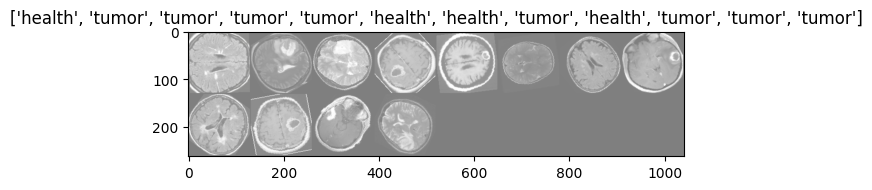

Batch of validation data


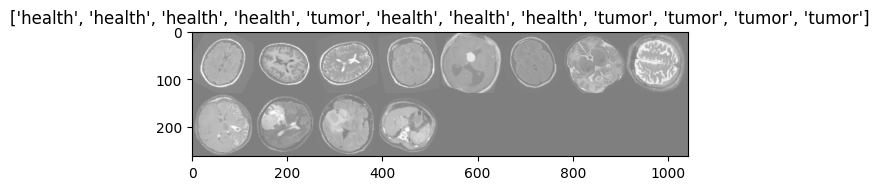

Batch of test data


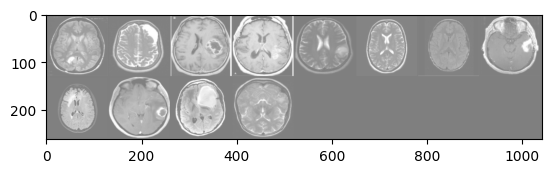

('gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test44.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test34.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test40.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test30.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test9.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test17.jpeg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test21.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test43.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test20.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test42.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test25.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex0

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs1, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs1)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs2, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs2)

imshow(out)

print(paths)

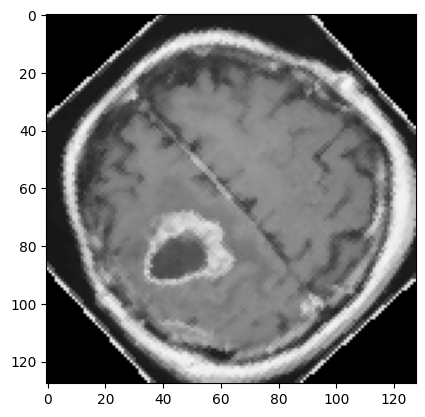

In [ ]:
# Visualização do dado que realmente será mandado para a rede
plt.imshow(inputs[3].numpy().transpose((1, 2, 0)))

# Treinando o modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() #anda de fato na direção que reduz o erro local

                # statistics
                running_loss += loss.item() * inputs.size(0) # loss é um tensor. item é usado para obter um float
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Testando o modelo

In [ ]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0


    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout()
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experiment 1

**No transfer learning:** Random initialization and all weights will be retrained.

In [ ]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_ft_randstart

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_ft_randstart, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7171 Acc: 0.5944
val Loss: 0.6522 Acc: 0.6613

Epoch 1/9
----------
train Loss: 0.6372 Acc: 0.6294
val Loss: 0.6486 Acc: 0.6613

Epoch 2/9
----------
train Loss: 0.6271 Acc: 0.6573
val Loss: 0.6398 Acc: 0.6613

Epoch 3/9
----------
train Loss: 0.6099 Acc: 0.7063
val Loss: 0.5920 Acc: 0.6613

Epoch 4/9
----------
train Loss: 0.5614 Acc: 0.7063
val Loss: 0.5666 Acc: 0.7419

Epoch 5/9
----------
train Loss: 0.6156 Acc: 0.6573
val Loss: 0.7113 Acc: 0.6613

Epoch 6/9
----------
train Loss: 0.5769 Acc: 0.7273
val Loss: 0.5801 Acc: 0.6129

Epoch 7/9
----------
train Loss: 0.5590 Acc: 0.6853
val Loss: 0.5486 Acc: 0.7581

Epoch 8/9
----------
train Loss: 0.4745 Acc: 0.7832
val Loss: 0.5404 Acc: 0.6774

Epoch 9/9
----------
train Loss: 0.4031 Acc: 0.8392
val Loss: 0.4840 Acc: 0.7581

Training complete in 0m 23s
Best val Acc: 0.758065


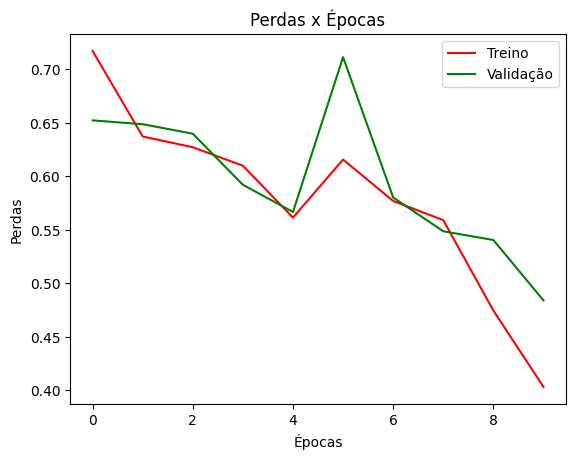

In [ ]:
num_epochs = np.arange(10)

#Gráfico de perdas
plt.title("Perdas x Épocas")
plt.plot(num_epochs ,LOSS_train, 'r', label='Treino')
plt.plot(num_epochs ,LOSS_val,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.legend()
plt.show()

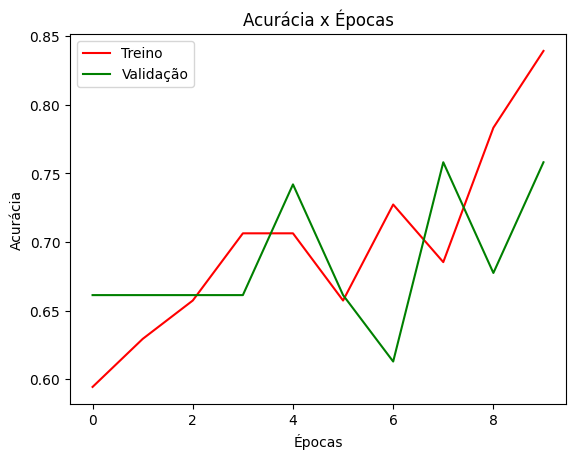

In [ ]:
#convertendo tensor em array
acc_train = []
acc_val = []
for c in range(len(num_epochs)):
  acc_train.append(ACC_train[c].cpu().numpy())
  acc_val.append(ACC_val[c].cpu().numpy())

#Gráfico de acurácia
plt.title("Acurácia x Épocas")
plt.plot(num_epochs ,acc_train, 'r', label='Treino')
plt.plot(num_epochs ,acc_val,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

path: test4.jpg / predicted: tumor


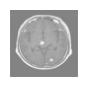

path: test18.jpg / predicted: tumor


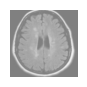

path: test7.JPG / predicted: health


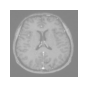

path: test40.JPG / predicted: tumor


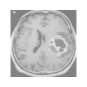

path: test17.jpeg / predicted: tumor


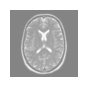

path: test44.JPG / predicted: tumor


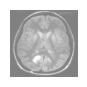

path: test47.JPG / predicted: tumor


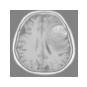

path: test12.jpg / predicted: health


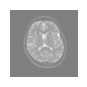

path: test15.jpeg / predicted: tumor


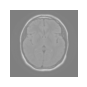

path: test27.jpg / predicted: tumor


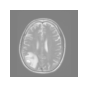

path: test46.JPG / predicted: tumor


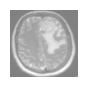

path: test11.jpg / predicted: health


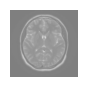

path: test43.JPG / predicted: tumor


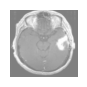

path: test1.jpg / predicted: tumor


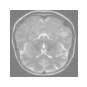

path: test23.jpeg / predicted: health


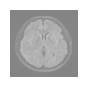

path: test35.JPG / predicted: tumor


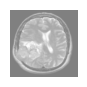

path: test37.JPG / predicted: tumor


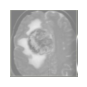

path: test6.JPG / predicted: health


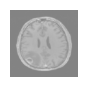

path: test32.JPG / predicted: tumor


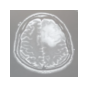

path: test48.JPG / predicted: tumor


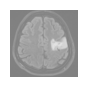

path: test14.jpg / predicted: tumor


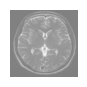

path: test9.JPG / predicted: tumor


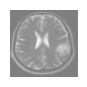

path: test19.png / predicted: tumor


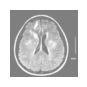

path: test21.jpg / predicted: health


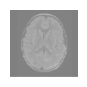

path: test13.jpg / predicted: health


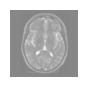

path: test5.jpg / predicted: tumor


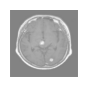

path: test3.jpg / predicted: tumor


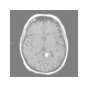

path: test45.JPG / predicted: tumor


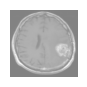

path: test16.jpg / predicted: tumor


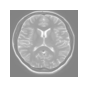

path: test39.JPG / predicted: tumor


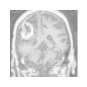

path: test26.jpg / predicted: tumor


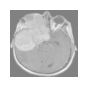

path: test8.jpg / predicted: tumor


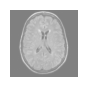

path: test33.JPG / predicted: tumor


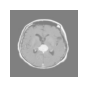

path: test28.jpg / predicted: tumor


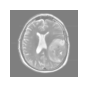

path: test34.JPG / predicted: tumor


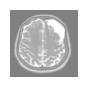

path: test22.jpg / predicted: health


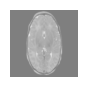

path: test25.jpg / predicted: tumor


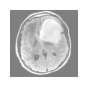

path: test41.jpg / predicted: tumor


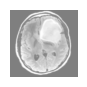

path: test2.jpg / predicted: health


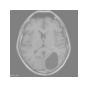

path: test10.JPG / predicted: tumor


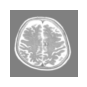

path: test20.jpg / predicted: tumor


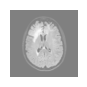

path: test29.JPG / predicted: tumor


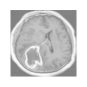

path: test42.jpg / predicted: tumor


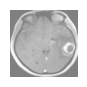

path: test38.JPG / predicted: tumor


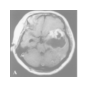

path: test30.JPG / predicted: tumor


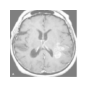

path: test36.JPG / predicted: tumor


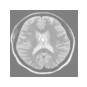

path: test24.jpg / predicted: tumor


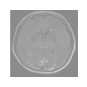

path: test31.JPG / predicted: tumor


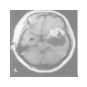

In [ ]:
test_model(model_ft_randstart)

# Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

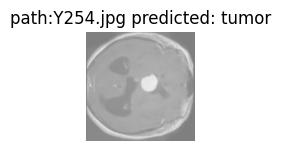

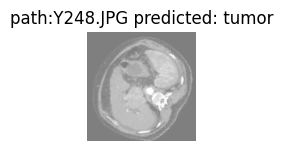

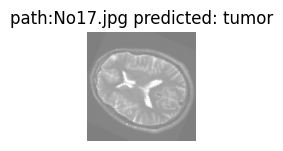

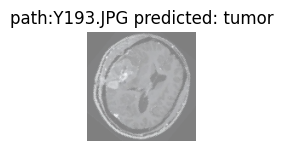

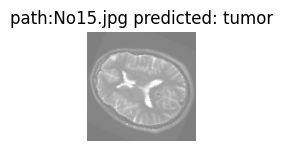

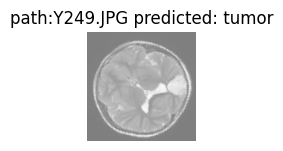

In [ ]:
visualize_model(model_ft_randstart)

Após modificar alguns valores na etapa inicial de organização dos dados, pensou-se em utilizar outros modelos de redes convolucionais com transfer learning para avaliar o desempenho do modelo. Assim, foram utilizadas as redes densenet121 e vgg_19. A primeira possui um estrutura bastante parecida com a Resnet18 e a segunda é bastante utilizada para reconhecimento de imagens em larga escala. Em ambos os casos foi utilizada a rede pré-treinada Imagenet.

## Experimento II --> DenseNet com transfer learning

In [ ]:
model2 = models.densenet121(pretrained='imagenet')
num_ftrs = model2.classifier.in_features
model2.classifier = nn.Linear(num_ftrs, 2)

model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()

# Aqui manteve-se o mesmo otimizador usado anteriormente, devido a sua rápida convergência para o local de menor erro
# Além disso, a taxa de aprendizado (lr) foi modificada para 0.001 valor com grande recorrência de uso em outros projetos
optimizer_model2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_model2, step_size=200, gamma=0.5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 168MB/s] 


In [ ]:
#Arquitetura da DenseNet
model2

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#TREINAMENTO

num_epochs=50                 #aumentou-se o número de épocas, visto que o modelo pode demorar um pouco para aprender e também devido a grande variação dos
                              #valores de acurácia durante o treinamento

model2 = train_model(model2, criterion, optimizer_model2, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6834 Acc: 0.6503
val Loss: 0.5354 Acc: 0.6935

Epoch 1/49
----------
train Loss: 0.3606 Acc: 0.8252
val Loss: 0.4376 Acc: 0.8226

Epoch 2/49
----------
train Loss: 0.1706 Acc: 0.9580
val Loss: 0.3624 Acc: 0.8710

Epoch 3/49
----------
train Loss: 0.1448 Acc: 0.9371
val Loss: 0.3937 Acc: 0.8548

Epoch 4/49
----------
train Loss: 0.0943 Acc: 0.9650
val Loss: 0.2623 Acc: 0.8871

Epoch 5/49
----------
train Loss: 0.0871 Acc: 0.9790
val Loss: 0.2721 Acc: 0.8871

Epoch 6/49
----------
train Loss: 0.0631 Acc: 0.9860
val Loss: 0.2005 Acc: 0.8871

Epoch 7/49
----------
train Loss: 0.1394 Acc: 0.9231
val Loss: 0.2069 Acc: 0.9355

Epoch 8/49
----------
train Loss: 0.0844 Acc: 0.9720
val Loss: 0.3430 Acc: 0.8226

Epoch 9/49
----------
train Loss: 0.0664 Acc: 0.9790
val Loss: 0.2545 Acc: 0.9032

Epoch 10/49
----------
train Loss: 0.1073 Acc: 0.9371
val Loss: 0.4032 Acc: 0.8387

Epoch 11/49
----------
train Loss: 0.0596 Acc: 0.9930
val Loss: 0.2602 Acc: 0.8710

Epoch 12/49
----------
t

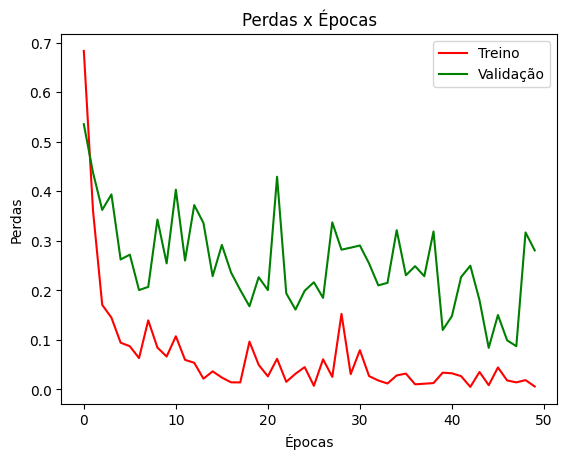

In [ ]:
#Gráfico de perdas

num_epochs = np.arange(50)            #vetor de épocas

#seleiona apenas os valores referentes a rede DenseNet (retira a parecela relacionada a rede Resnet)
LOSS_train2 = LOSS_train[10:]
LOSS_val2 = LOSS_val[10:]
ACC_train2 = ACC_train[10:]
ACC_val2 = ACC_val[10:]


plt.title("Perdas x Épocas")
plt.plot(num_epochs ,LOSS_train2, 'r', label='Treino')
plt.plot(num_epochs ,LOSS_val2,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.legend()
plt.show()

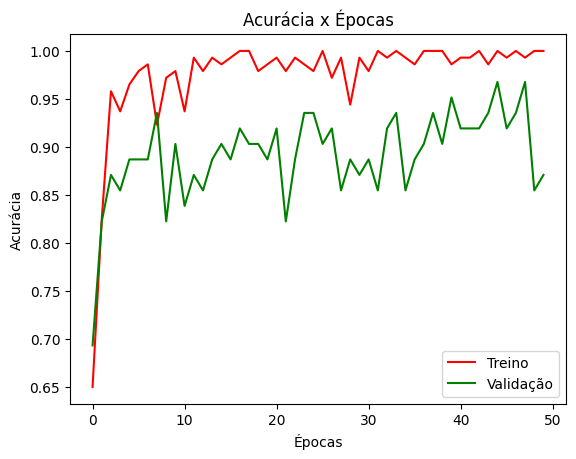

In [ ]:
#convertendo tensor em array
acc_train2 = []
acc_val2 = []
for c in range(len(num_epochs)):
  acc_train2.append(ACC_train2[c].cpu().numpy())
  acc_val2.append(ACC_val2[c].cpu().numpy())

#Gráfico de acurácia
plt.title("Acurácia x Épocas")
plt.plot(num_epochs ,acc_train2, 'r', label='Treino')
plt.plot(num_epochs ,acc_val2,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


path: test30.JPG / predicted: health


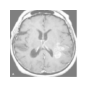

path: test11.jpg / predicted: health


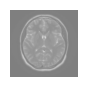

path: test32.JPG / predicted: tumor


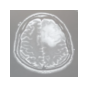

path: test37.JPG / predicted: tumor


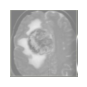

path: test45.JPG / predicted: tumor


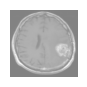

path: test36.JPG / predicted: health


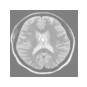

path: test35.JPG / predicted: tumor


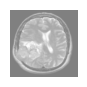

path: test39.JPG / predicted: tumor


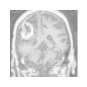

path: test23.jpeg / predicted: health


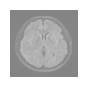

path: test47.JPG / predicted: tumor


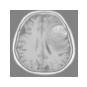

path: test26.jpg / predicted: tumor


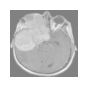

path: test17.jpeg / predicted: health


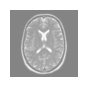

path: test24.jpg / predicted: tumor


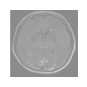

path: test22.jpg / predicted: health


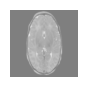

path: test7.JPG / predicted: health


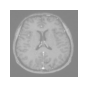

path: test16.jpg / predicted: health


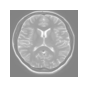

path: test15.jpeg / predicted: health


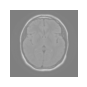

path: test21.jpg / predicted: health


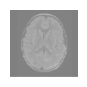

path: test1.jpg / predicted: health


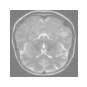

path: test8.jpg / predicted: health


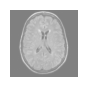

path: test43.JPG / predicted: tumor


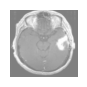

path: test46.JPG / predicted: tumor


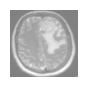

path: test29.JPG / predicted: tumor


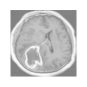

path: test19.png / predicted: health


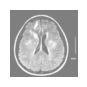

path: test28.jpg / predicted: tumor


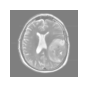

path: test4.jpg / predicted: tumor


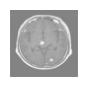

path: test5.jpg / predicted: tumor


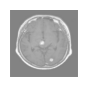

path: test27.jpg / predicted: tumor


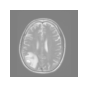

path: test6.JPG / predicted: health


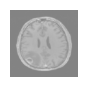

path: test40.JPG / predicted: tumor


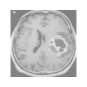

path: test12.jpg / predicted: health


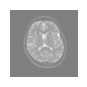

path: test13.jpg / predicted: health


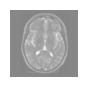

path: test20.jpg / predicted: health


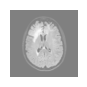

path: test48.JPG / predicted: tumor


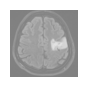

path: test42.jpg / predicted: tumor


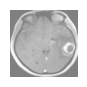

path: test41.jpg / predicted: tumor


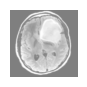

path: test38.JPG / predicted: tumor


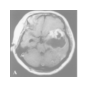

path: test10.JPG / predicted: health


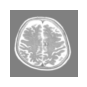

path: test9.JPG / predicted: tumor


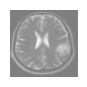

path: test34.JPG / predicted: tumor


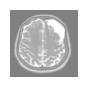

path: test18.jpg / predicted: health


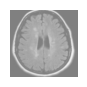

path: test33.JPG / predicted: tumor


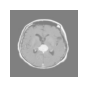

path: test14.jpg / predicted: health


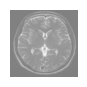

path: test25.jpg / predicted: tumor


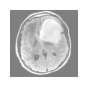

path: test3.jpg / predicted: health


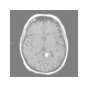

path: test2.jpg / predicted: health


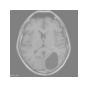

path: test44.JPG / predicted: tumor


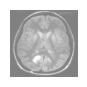

path: test31.JPG / predicted: tumor


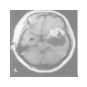

In [ ]:
#Modelo de teste --> Testa o modelo
test_model(model2)

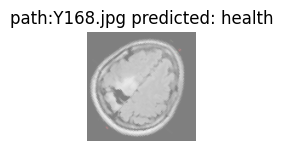

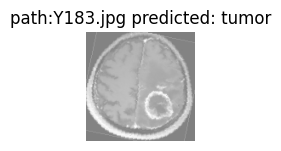

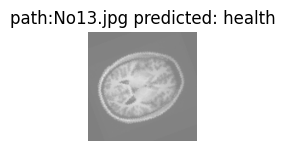

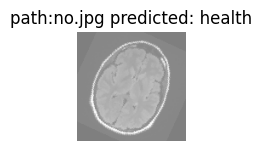

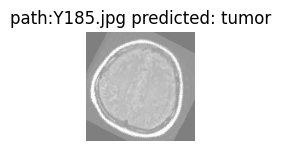

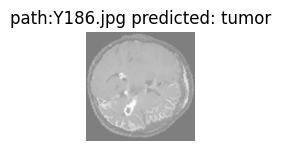

In [ ]:
visualize_model(model2)

## Experimento III --> VGG com transfer learning

In [ ]:
model3 = models.vgg19(pretrained='imagenet')

#######################################################################
#Etapas para utilizar a vgg19 no nosso conjunto de dados

# Número de filtros na última camada
num_ftrs = model3.classifier[6].in_features
# Converte todas as camadas em lista e exclui a última camada
features = list(model3.classifier.children())[:-1]
# Adiciona na última camada da rede uma camada referente a saída do nosso modelo (2 classes)
features.extend([nn.Linear(num_ftrs, 2)])
# Agrupa as alterações na rede
model3.classifier = nn.Sequential(*features)
#########################################################################

model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_model3 = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_model3, step_size=200, gamma=0.5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 218MB/s]


In [ ]:
#Arquitetura da VGG19
model3

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#TREINAMENTO
num_epochs=50

model3 = train_model(model3, criterion, optimizer_model3, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------
train Loss: 0.7195 Acc: 0.5944
val Loss: 0.7343 Acc: 0.4677

Epoch 1/49
----------
train Loss: 0.5700 Acc: 0.7133
val Loss: 0.4772 Acc: 0.7258

Epoch 2/49
----------
train Loss: 0.3769 Acc: 0.8462
val Loss: 0.4319 Acc: 0.7903

Epoch 3/49
----------
train Loss: 0.3539 Acc: 0.8671
val Loss: 0.3270 Acc: 0.9194

Epoch 4/49
----------
train Loss: 0.1810 Acc: 0.9301
val Loss: 0.4740 Acc: 0.8548

Epoch 5/49
----------
train Loss: 0.2941 Acc: 0.8881
val Loss: 0.4736 Acc: 0.8226

Epoch 6/49
----------
train Loss: 0.2778 Acc: 0.8881
val Loss: 0.2928 Acc: 0.8710

Epoch 7/49
----------
train Loss: 0.1763 Acc: 0.9441
val Loss: 0.2204 Acc: 0.8871

Epoch 8/49
----------
train Loss: 0.1597 Acc: 0.9441
val Loss: 1.2706 Acc: 0.6129

Epoch 9/49
----------
train Loss: 0.2913 Acc: 0.8671
val Loss: 0.2526 Acc: 0.8710

Epoch 10/49
----------
train Loss: 0.2150 Acc: 0.9161
val Loss: 0.3269 Acc: 0.8548

Epoch 11/49
----------
train Loss: 0.0724 Acc: 0.9790
val Loss: 0.3563 Acc: 0.8548

Ep

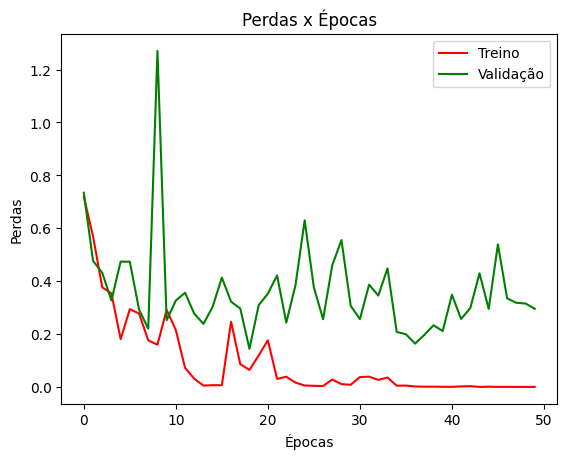

In [ ]:
#Gráfico de perdas

#seleiona apenas os valores referentes a rede VGG (retira a parecela relacionada a rede Resnet e DenseNet)
LOSS_train3 = LOSS_train[60:]
LOSS_val3 = LOSS_val[60:]
ACC_train3 = ACC_train[60:]
ACC_val3 = ACC_val[60:]

num_epochs = np.arange(num_epochs)

plt.title("Perdas x Épocas")
plt.plot(num_epochs ,LOSS_train3, 'r', label='Treino')
plt.plot(num_epochs ,LOSS_val3,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.legend()
plt.show()

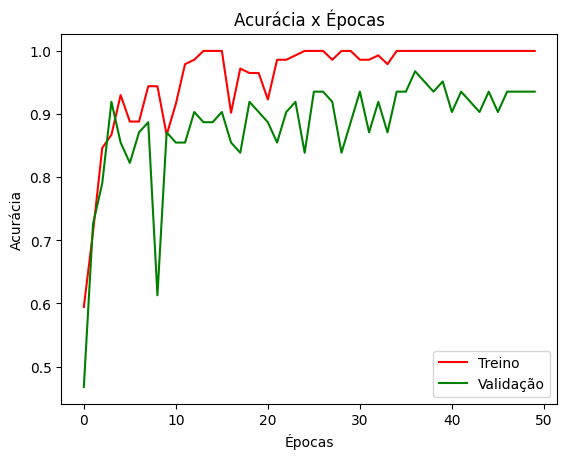

In [ ]:
#convertendo tensor em array
acc_train3 = []
acc_val3 = []
for c in range(len(num_epochs)):
  acc_train3.append(ACC_train3[c].cpu().numpy())
  acc_val3.append(ACC_val3[c].cpu().numpy())

#Gráfico de acurácia
plt.title("Acurácia x Épocas")
plt.plot(num_epochs ,acc_train3, 'r', label='Treino')
plt.plot(num_epochs ,acc_val3,'g', label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

path: test46.JPG / predicted: tumor


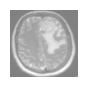

path: test15.jpeg / predicted: health


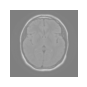

path: test7.JPG / predicted: health


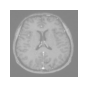

path: test10.JPG / predicted: health


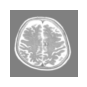

path: test23.jpeg / predicted: health


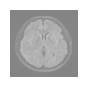

path: test14.jpg / predicted: health


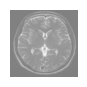

path: test5.jpg / predicted: tumor


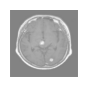

path: test1.jpg / predicted: health


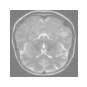

path: test45.JPG / predicted: tumor


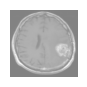

path: test19.png / predicted: tumor


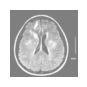

path: test35.JPG / predicted: tumor


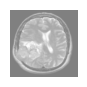

path: test36.JPG / predicted: tumor


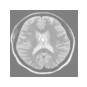

path: test37.JPG / predicted: tumor


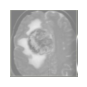

path: test43.JPG / predicted: tumor


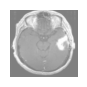

path: test8.jpg / predicted: health


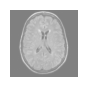

path: test40.JPG / predicted: tumor


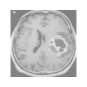

path: test39.JPG / predicted: tumor


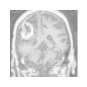

path: test18.jpg / predicted: health


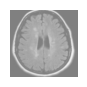

path: test6.JPG / predicted: health


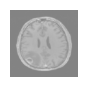

path: test12.jpg / predicted: health


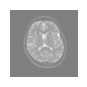

path: test24.jpg / predicted: tumor


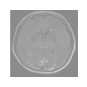

path: test34.JPG / predicted: tumor


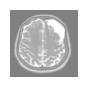

path: test33.JPG / predicted: tumor


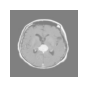

path: test27.jpg / predicted: tumor


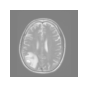

path: test42.jpg / predicted: tumor


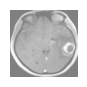

path: test25.jpg / predicted: tumor


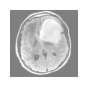

path: test3.jpg / predicted: tumor


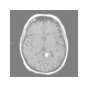

path: test9.JPG / predicted: tumor


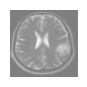

path: test26.jpg / predicted: tumor


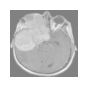

path: test44.JPG / predicted: tumor


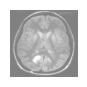

path: test22.jpg / predicted: health


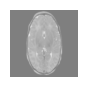

path: test31.JPG / predicted: tumor


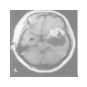

path: test28.jpg / predicted: tumor


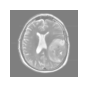

path: test38.JPG / predicted: tumor


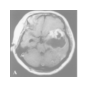

path: test32.JPG / predicted: tumor


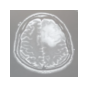

path: test16.jpg / predicted: health


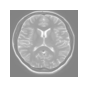

path: test2.jpg / predicted: tumor


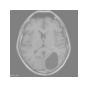

path: test13.jpg / predicted: health


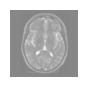

path: test21.jpg / predicted: health


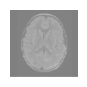

path: test30.JPG / predicted: tumor


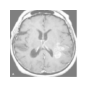

path: test41.jpg / predicted: tumor


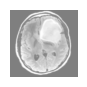

path: test47.JPG / predicted: tumor


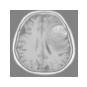

path: test20.jpg / predicted: health


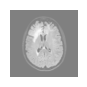

path: test17.jpeg / predicted: health


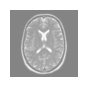

path: test4.jpg / predicted: tumor


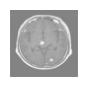

path: test11.jpg / predicted: health


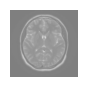

path: test48.JPG / predicted: tumor


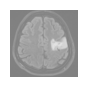

path: test29.JPG / predicted: tumor


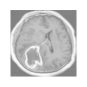

In [ ]:
#Modelo de teste --> Testa o modelo
test_model(model3)

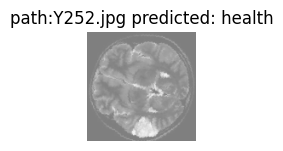

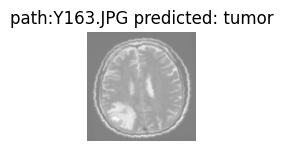

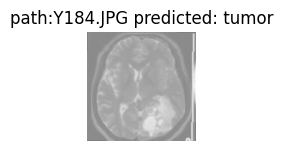

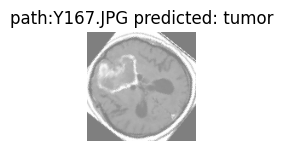

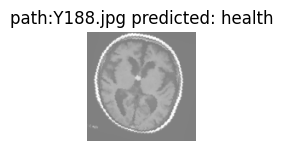

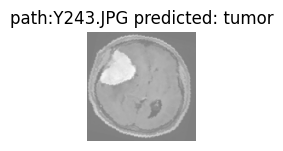

In [ ]:
visualize_model(model3)

Observou-se que as redes chegaram a resultados bastante próximos, mesmo a arquitetura da VGG sendo um pouco menor quando comparado a DenseNet. Além disso, notou-se que a VGG teve em algumas épocas oscilações maiores do que a DenseNet. No geral, ambas as redes alcançaram pontuação maior que 90% com base nos dados de validação, sendo o melhor desempenho o de 96%.
Como resultado final, utilizou-se as predições da DensetNet, que analisando visualmente cada imagem de teste parece ter de fato classificado a grande maioria de maneira correta.